# Домашнее задание 1.1. Обратное распространение ошибки на Pytorch-графе

На основании функции по варианту необходимо:
1. Построить nn.Module, в котором вы определите `forward`и `my_forward_backward`
2. `forward` должен повторять функцию, выданную вам по варианту, `my_forward_backward` описывает проход по вычислителному графу, а также вычисление градиентов по этому графу с помощью backprop. Градиенты должны быть рассчитаны для параметров $w0, w1$, тензоры $x1, x2, x3$ считаются входными данными сети
3. Необходимо удалять неиспользуемые тензоры, как это делает Pytorch
4. Если какие-то узлы не нужны для вычисления результата, то вы не должны их вычислять в процессе backprop
5. Необходимо построить визуализацию вычислительного графа с помощью onnx и netron.app

Все материалы для выполнения задания можно найти в ноутбуках второго и третьего семинаров, а также в этом ноутбуке есть пример выполненного задания

In [1]:
import torch
from torch import nn
from torch.fx import symbolic_trace

In [2]:
def v8():  # Иван Шумаков
  r1 = x3 * (w0 ** 2 + w1 ** 2)
  r2 = (x3 + w0 / w1) * (3 * w0 + x3 * w1)
  r3 = x3 - (w1 - x2) ** 2 / w0
  return r1 + r2 + r3 / (x1 - x2 - r1)

In [3]:
def test_model_class(model_class):

    model = model_class()

    for _ in range(10):

        x1, x2, x3 = torch.rand(3)
        model.zero_grad()
        y_torch = model(x1, x2, x3)
        y_torch.backward()
        grad_torch = model.w.grad.clone()


        model.zero_grad()
        with torch.no_grad():
            y_manual = model.your_forward_backward(x1, x2, x3)
        grad_manual = model.w.grad.clone()

        assert torch.allclose(y_manual, y_torch, rtol=5e-05, atol=1e-7)
        assert torch.allclose(grad_manual, grad_torch, rtol=5e-05, atol=1e-7)

    print('Tests completed successfully!')

In [4]:
class Graph(nn.Module):

    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor([0.950, 0.288], dtype=torch.float32))

    def forward(self, X):
        x1, x2, x3 = X
        w0 = self.w[0]
        w1 = self.w[1]
        r1 = x3 * (w0 ** 2 + w1 ** 2)
        r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        r3 = x3 - (w1 - x2) ** 2 / w0
        return r1 + r2 + r3 / (x1 - x2 - r1)

    def your_forward_backward(self, x1, x2, x3):
        w0 = self.w[0]
        w1 = self.w[1]

        # forward
        t1 = w0 ** 2
        t2 = w1 ** 2
        t3 = t1 + t2
        t1 = t2 = None
        t4 = t3 * x3 #r1
        t3 = None

        t5 = w1 * x3
        t6 = 3.0 * w0
        t7 = t5 + t6
        t5 = t6 = None
        t8 = w0 / w1
        t9 = x3 + t8
        t8 = None
        t10 = t7 * t9 #r2
        
        t11 = w1 - x2 
        t12 = t11 ** 2
        t13 = t12 / w0 
        t14 = x3 - t13 #r3
        t13 = None

        t15 = x1 - x2
        t16 = t15 - t4
        t15 = None
        t17 = t14 / t16
        t18 = t17 + t10
        t17 = None
        t10 = None
        t19 = t18 + t4 #res
        t4 = t18 = None

        # backward
        #dw0
        dt8dw0 = 1.0 / w1
        dt9dw0 = dt8dw0
        dt8dw0 = None
        dt10dt9 = t7
        t7 = None
        dt6dw0 = 3.0
        dt7dt6 = 1.0 
        dt5dw0 = 0.0
        dt7dt5 = 1.0
        dt7dw0 = dt7dt5 * dt5dw0 + dt7dt6 * dt6dw0
        dt10dt7 = t9 
        t9 = None
        dt10dw0 = dt10dt7 * dt7dw0 + dt10dt9 * dt9dw0
        dt9dw0 = dt7dw0 = None

        dt11dw0 = 0.0
        dt12dt11 = 2.0 * t11
        t11 = None
        dt12dw0 = dt12dt11 * dt11dw0
        dt13dt12 = 1.0 / w0
        dt13dw0 = dt13dt12 * dt12dw0 - t12 / (w0 ** 2)
        t12 = dt12dw0 = None
        dt14dt13 = -1.0
        dt14dw0 = dt14dt13 * dt13dw0
        dt13dw0 = None
        dt17dt14 = 1.0 / t16

        dt3dw0 = 2.0 * w0
        dt4dt3 = x3
        dt4dw0 = dt4dt3 * dt3dw0
        dt3dw0 = None
        dt16dt4 = -1.0
        dt15dw0 = 0.0
        dt16dt15 = 1.0
        dt16dw0 = dt16dt15 * dt15dw0 + dt16dt4 * dt4dw0
        dt17dt16 = - t14 / (t16 ** 2)
        t14 = t16 = None
        dt17dw0 = dt17dt16 * dt16dw0 + dt17dt14 * dt14dw0
        dt14dw0 = dt16dw0 = None
        dw0 = dt17dw0 + dt10dw0 + dt4dw0 
        dt10dw0 = dt4dw0 = dt17dw0 = None

        #dw1
        dt8dw1 = w0 * (- 1 / (w1 ** 2))
        dt9dw1 = dt8dw1
        dt8dw1 = None

        dt6dw1 = 0.0
        dt5dw1 = x3
        dt7dw1 = dt7dt5 * dt5dw1 + dt7dt6 * dt6dw1
        dt10dw1 = dt10dt7 * dt7dw1 + dt10dt9 * dt9dw1
        dt10dt9 = dt9dw1 = dt7dw1 = None

        dt3dw1 = 2.0 * w1
        dt4dw1 = dt4dt3 * dt3dw1
        dt3dw1 = None
        dt15dw1 = 0.0
        dt16dw1 = dt16dt15 * dt15dw1 + dt16dt4 * dt4dw1

        dt11dw1 = 1.0
        dt12dw1 = dt12dt11 * dt11dw1
        dt13dw1 = dt13dt12 * dt12dw1
        dt13dt12 = dt12dw1 = None
        dt14dw1 = dt14dt13 * dt13dw1
        dt13dw1 = None
        dt17dw1 = dt17dt14 * dt14dw1 + dt17dt16 * dt16dw1
        dt17dt14 = dt17dt16 = dt16dw1 = dt14dw1 = None
        dw1 = dt17dw1 + dt10dw1 + dt4dw1
        dt10dw1 = dt4dw1 = dt17dw1 = None

        self.w.grad = torch.stack([dw0, dw1])

        return t19

In [5]:
#torch._inductor.config.trace.enabled = True

In [6]:
# 1. Здесь скомпилируйте forward граф через torch.compile
model = Graph()
compiled_model = torch.compile(model)


In [7]:
# Здесь тестируется построенная вами модель
test_model_class(Graph)

TypeError: Graph.forward() takes 2 positional arguments but 4 were given

In [ ]:
# Backward graph from torch_compile_debug/run_2024_10_03_15_17_05_632967-pid_20079/torchinductor/model__0_backward_12.1/fx_graph_readable.py
 
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: "f32[2]", primals_2: "f32[]", primals_3: "f32[]", sub_3: "f32[]", tangents_1: "f32[]"):
        # File: /home/azor/projects/Sber-ML/model-debug.py:10 in forward, code: w0 = self.w[0]
        select: "f32[]" = torch.ops.aten.select.int(primals_1, 0, 0)
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:11 in forward, code: w1 = self.w[1]
        select_1: "f32[]" = torch.ops.aten.select.int(primals_1, 0, 1);  primals_1 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        div: "f32[]" = torch.ops.aten.div.Tensor(select, select_1)
        add_1: "f32[]" = torch.ops.aten.add.Tensor(primals_2, div)
        mul_1: "f32[]" = torch.ops.aten.mul.Tensor(select, 3.0)
        mul_2: "f32[]" = torch.ops.aten.mul.Tensor(primals_2, select_1)
        add_2: "f32[]" = torch.ops.aten.add.Tensor(mul_1, mul_2);  mul_1 = mul_2 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:14 in forward, code: r3 = x3 - (w1 - x2) ** 2 / w0
        sub: "f32[]" = torch.ops.aten.sub.Tensor(select_1, primals_3);  primals_3 = None
        pow_3: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(sub, 2)
        div_1: "f32[]" = torch.ops.aten.div.Tensor(pow_3, select);  pow_3 = None
        sub_1: "f32[]" = torch.ops.aten.sub.Tensor(primals_2, div_1)
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:15 in forward, code: return r1 + r2 + r3 / (x1 - x2 - r1)
        div_2: "f32[]" = torch.ops.aten.div.Tensor(sub_1, sub_3);  sub_1 = None
        div_4: "f32[]" = torch.ops.aten.div.Tensor(div_2, sub_3);  div_2 = None
        neg: "f32[]" = torch.ops.aten.neg.default(tangents_1)
        mul_4: "f32[]" = torch.ops.aten.mul.Tensor(neg, div_4);  neg = div_4 = None
        div_5: "f32[]" = torch.ops.aten.div.Tensor(tangents_1, sub_3);  sub_3 = None
        neg_1: "f32[]" = torch.ops.aten.neg.default(mul_4);  mul_4 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:15 in forward, code: return r1 + r2 + r3 / (x1 - x2 - r1)
        add_5: "f32[]" = torch.ops.aten.add.Tensor(neg_1, tangents_1);  neg_1 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:14 in forward, code: r3 = x3 - (w1 - x2) ** 2 / w0
        neg_2: "f32[]" = torch.ops.aten.neg.default(div_5);  div_5 = None
        div_7: "f32[]" = torch.ops.aten.div.Tensor(div_1, select);  div_1 = None
        neg_3: "f32[]" = torch.ops.aten.neg.default(neg_2)
        mul_5: "f32[]" = torch.ops.aten.mul.Tensor(neg_3, div_7);  neg_3 = div_7 = None
        div_8: "f32[]" = torch.ops.aten.div.Tensor(neg_2, select);  neg_2 = None
        pow_4: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(sub, 1.0);  sub = None
        mul_6: "f32[]" = torch.ops.aten.mul.Scalar(pow_4, 2.0);  pow_4 = None
        mul_7: "f32[]" = torch.ops.aten.mul.Tensor(div_8, mul_6);  div_8 = mul_6 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        mul_8: "f32[]" = torch.ops.aten.mul.Tensor(tangents_1, add_1);  add_1 = None
        mul_9: "f32[]" = torch.ops.aten.mul.Tensor(tangents_1, add_2);  tangents_1 = add_2 = None
        mul_10: "f32[]" = torch.ops.aten.mul.Tensor(mul_8, primals_2)
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        add_6: "f32[]" = torch.ops.aten.add.Tensor(mul_7, mul_10);  mul_7 = mul_10 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        mul_11: "f32[]" = torch.ops.aten.mul.Tensor(mul_8, 3.0);  mul_8 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        add_7: "f32[]" = torch.ops.aten.add.Tensor(mul_5, mul_11);  mul_5 = mul_11 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        div_10: "f32[]" = torch.ops.aten.div.Tensor(div, select_1);  div = None
        neg_4: "f32[]" = torch.ops.aten.neg.default(mul_9)
        mul_12: "f32[]" = torch.ops.aten.mul.Tensor(neg_4, div_10);  neg_4 = div_10 = None
        div_11: "f32[]" = torch.ops.aten.div.Tensor(mul_9, select_1);  mul_9 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        add_8: "f32[]" = torch.ops.aten.add.Tensor(add_7, div_11);  add_7 = div_11 = None
        add_9: "f32[]" = torch.ops.aten.add.Tensor(add_6, mul_12);  add_6 = mul_12 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:12 in forward, code: r1 = x3 * (w0 ** 2 + w1 ** 2)
        mul_13: "f32[]" = torch.ops.aten.mul.Tensor(add_5, primals_2);  add_5 = primals_2 = None
        pow_5: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(select_1, 1.0);  select_1 = None
        mul_14: "f32[]" = torch.ops.aten.mul.Scalar(pow_5, 2.0);  pow_5 = None
        mul_15: "f32[]" = torch.ops.aten.mul.Tensor(mul_13, mul_14);  mul_14 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:12 in forward, code: r1 = x3 * (w0 ** 2 + w1 ** 2)
        add_10: "f32[]" = torch.ops.aten.add.Tensor(add_9, mul_15);  add_9 = mul_15 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:12 in forward, code: r1 = x3 * (w0 ** 2 + w1 ** 2)
        pow_6: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(select, 1.0);  select = None
        mul_16: "f32[]" = torch.ops.aten.mul.Scalar(pow_6, 2.0);  pow_6 = None
        mul_17: "f32[]" = torch.ops.aten.mul.Tensor(mul_13, mul_16);  mul_13 = mul_16 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:12 in forward, code: r1 = x3 * (w0 ** 2 + w1 ** 2)
        add_11: "f32[]" = torch.ops.aten.add.Tensor(add_8, mul_17);  add_8 = mul_17 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:11 in forward, code: w1 = self.w[1]
        full_default: "f32[2]" = torch.ops.aten.full.default([2], 0, dtype = torch.float32, layout = torch.strided, device = device(type='cpu'), pin_memory = False)
        select_scatter: "f32[2]" = torch.ops.aten.select_scatter.default(full_default, add_10, 0, 1);  add_10 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:10 in forward, code: w0 = self.w[0]
        select_scatter_1: "f32[2]" = torch.ops.aten.select_scatter.default(full_default, add_11, 0, 0);  full_default = add_11 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:10 in forward, code: w0 = self.w[0]
        add_12: "f32[2]" = torch.ops.aten.add.Tensor(select_scatter, select_scatter_1);  select_scatter = select_scatter_1 = None
        return [add_12, None, None, None]
        

In [ ]:
# Forward from torch_compile_debug/run_2024_10_03_15_17_05_632967-pid_20079/torchinductor/model__0_forward_10.0/fx_graph_readable.py
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: "f32[2]", primals_2: "f32[]", primals_3: "f32[]", primals_4: "f32[]"):
        # File: /home/azor/projects/Sber-ML/model-debug.py:10 in forward, code: w0 = self.w[0]
        select: "f32[]" = torch.ops.aten.select.int(primals_1, 0, 0)
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:11 in forward, code: w1 = self.w[1]
        select_1: "f32[]" = torch.ops.aten.select.int(primals_1, 0, 1)
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:12 in forward, code: r1 = x3 * (w0 ** 2 + w1 ** 2)
        pow_1: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(select, 2)
        pow_2: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(select_1, 2)
        add: "f32[]" = torch.ops.aten.add.Tensor(pow_1, pow_2);  pow_1 = pow_2 = None
        mul: "f32[]" = torch.ops.aten.mul.Tensor(primals_2, add);  add = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:13 in forward, code: r2 = (x3 + w0 / w1) * (3.0 * w0 + x3 * w1)
        div: "f32[]" = torch.ops.aten.div.Tensor(select, select_1)
        add_1: "f32[]" = torch.ops.aten.add.Tensor(primals_2, div);  div = None
        mul_1: "f32[]" = torch.ops.aten.mul.Tensor(select, 3.0)
        mul_2: "f32[]" = torch.ops.aten.mul.Tensor(primals_2, select_1)
        add_2: "f32[]" = torch.ops.aten.add.Tensor(mul_1, mul_2);  mul_1 = mul_2 = None
        mul_3: "f32[]" = torch.ops.aten.mul.Tensor(add_1, add_2);  add_1 = add_2 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:14 in forward, code: r3 = x3 - (w1 - x2) ** 2 / w0
        sub: "f32[]" = torch.ops.aten.sub.Tensor(select_1, primals_3);  select_1 = None
        pow_3: "f32[]" = torch.ops.aten.pow.Tensor_Scalar(sub, 2);  sub = None
        div_1: "f32[]" = torch.ops.aten.div.Tensor(pow_3, select);  pow_3 = select = None
        sub_1: "f32[]" = torch.ops.aten.sub.Tensor(primals_2, div_1);  div_1 = None
        
        # File: /home/azor/projects/Sber-ML/model-debug.py:15 in forward, code: return r1 + r2 + r3 / (x1 - x2 - r1)
        add_3: "f32[]" = torch.ops.aten.add.Tensor(mul, mul_3);  mul_3 = None
        sub_2: "f32[]" = torch.ops.aten.sub.Tensor(primals_4, primals_3);  primals_4 = None
        sub_3: "f32[]" = torch.ops.aten.sub.Tensor(sub_2, mul);  sub_2 = mul = None
        div_2: "f32[]" = torch.ops.aten.div.Tensor(sub_1, sub_3);  sub_1 = None
        add_4: "f32[]" = torch.ops.aten.add.Tensor(add_3, div_2);  add_3 = div_2 = None
        return [add_4, primals_1, primals_2, primals_3, sub_3]

# Выводы
В случае с дебаг дампом выражение на одной строчке могут быть разбиты на несколько блоков.
При построении ручного графа был применены вычисления в глубину, которые позволяли получать значения r1, r2, r3 поочереди. 

In [ ]:
# Symbolic trace:
symbolic_traced : torch.fx.GraphModule = symbolic_trace(model)

In [ ]:
print(symbolic_traced.graph)

graph():
    %x : [num_users=3] = placeholder[target=X]
    %getitem : [num_users=1] = call_function[target=operator.getitem](args = (%x, 0), kwargs = {})
    %getitem_1 : [num_users=2] = call_function[target=operator.getitem](args = (%x, 1), kwargs = {})
    %getitem_2 : [num_users=4] = call_function[target=operator.getitem](args = (%x, 2), kwargs = {})
    %w : [num_users=2] = get_attr[target=w]
    %getitem_3 : [num_users=4] = call_function[target=operator.getitem](args = (%w, 0), kwargs = {})
    %getitem_4 : [num_users=4] = call_function[target=operator.getitem](args = (%w, 1), kwargs = {})
    %pow_1 : [num_users=1] = call_function[target=operator.pow](args = (%getitem_3, 2), kwargs = {})
    %pow_2 : [num_users=1] = call_function[target=operator.pow](args = (%getitem_4, 2), kwargs = {})
    %add : [num_users=1] = call_function[target=operator.add](args = (%pow_1, %pow_2), kwargs = {})
    %mul : [num_users=2] = call_function[target=operator.mul](args = (%getitem_2, %add), kwargs

In [ ]:
input = torch.rand(3)

In [ ]:
# А сюда вы должны вставить визуализацию forward'а
# 1. Сконвертируйте forward через onnx
# 2. Визуализируйте через Netron.app
onnx_program = torch.onnx.export(model, input, "./trace.onnx", opset_version = 11)

/tmp/ipykernel_5139/28502400.py:8: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  x1, x2, x3 = X


Получившийся граф:
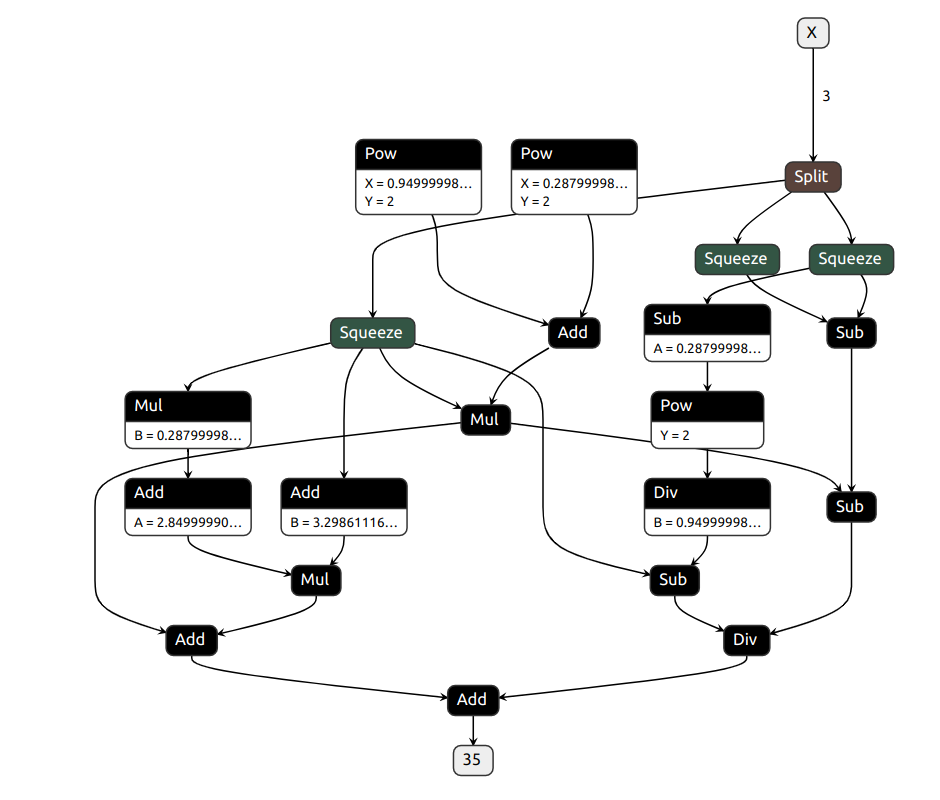
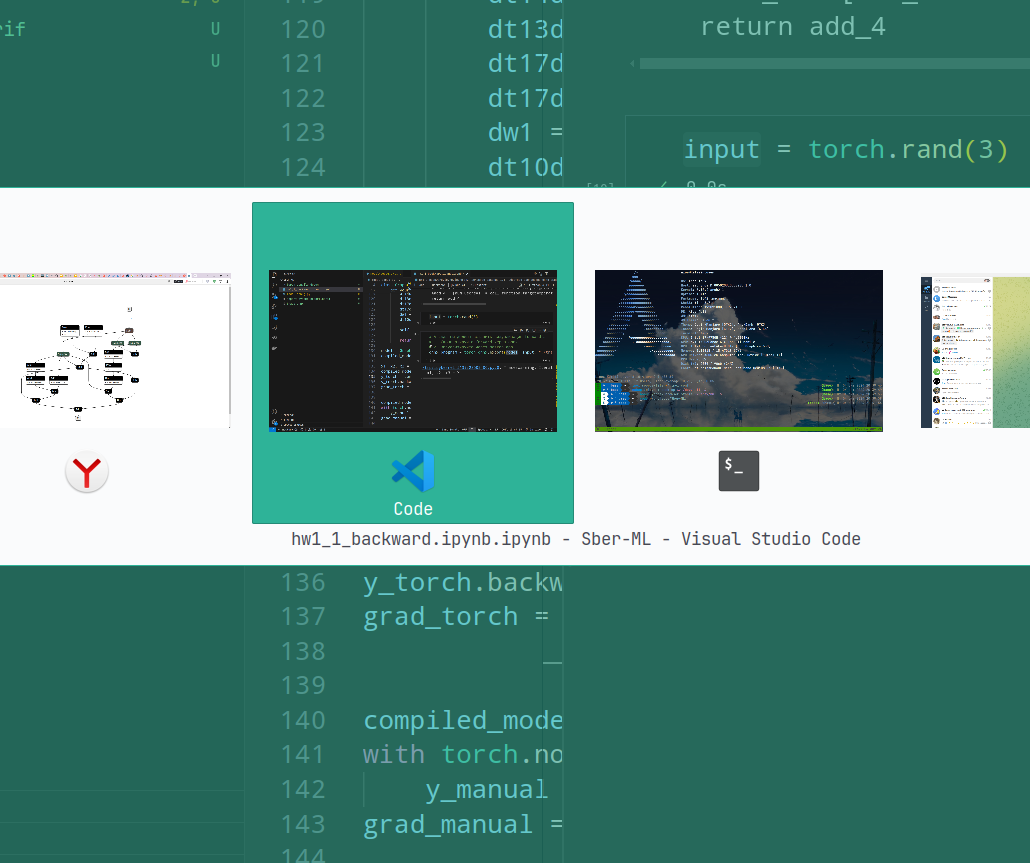